# From web-scrapping to dashboarding of scrapped data

My first hands-on experience with web scrapping and dashboarding data with python. Here, I am interested in shoe e-commerce: I look on the internet shoe shop of zalando and extract several of their most popular women shoes. Data points collecte were model name, brand, price, price reduction, as well as shoe type. Data was collected in summer 2023. To automate the dataframe generation, scrapping was done in two stages: first the urls of most popular shoes were scrapped with selenium. Then shoe attributes were fetched with cfscrape (basically like requests). Then I do an exploratory data analysis followed by dashboarding. The dashboard is kinda cheating: I used ChatGPT as a primer for it (still doing hands-on EDA saved me... see below...).

## Table of contents:

[1. Scrap urls of Zalando's most popular shoes](#1.-Scrap-urls-of-Zalando's-most-popular-shoes)
[2. Scrap shoe attributes](#2.-Scrap-shoe-attributes)
[3. EDA of scraped data](#3.-EDA-of-scraped-data)
[4. Actual dashboarding with dash](#4.-Actual-dashboarding-with-dash)
[5. Outtakes](#5.-Outtakes)

##

## 1. Scrap urls of Zalando's most popular shoes 

In [6]:
### install required libraries

#! conda create --name atoti.
#! conda activate atoti

#! pip install requests # 2.27.1
#! pip install beautifulsoup4 #4.11.1
#! pip install selenium # 4.11.2
#! pip install webdriver_manager #4.0.0
#! pip install progress #1.6.
#! pip install cfscrape #2.1.1

#! pip install squarify # 0.4.3
#! pip install --upgrade seaborn numpy
#! pip install --upgrade plotly
#! pip install dash-html-components #2.0.0                                        
#! pip install dash-core-components #2.0.0
#! pip install dash --upgrade
#! pip install Flask==2.1.0

In [ ]:
### import libraries for selenium

import time
import lxml.html as html
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC, wait
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
from selenium.webdriver.firefox.options import Options

In [ ]:
### define function to handle dynamic webpages by scrolling down with selenium

# example: https://stackoverflow.com/questions/54870270/getting-list-of-likers-for-an-instagram-post-python-selenium/54882356#54882356

def scroll_down_all(driver, pause_sec=1):

# Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
    # Scroll down
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Pause
        time.sleep(pause_sec)

    # After scroll down, get current height.
        new_height = driver.execute_script("return document.body.scrollHeight")
    
        if new_height == last_height:
            break
        last_height = new_height
    

In [ ]:
### define options for webdriver

options = Options()
options.add_argument("--ignore-certificate-errors")
options.add_argument("--incognito")
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

In [ ]:
### scrap first shoe page for single shoe urls

from bs4 import BeautifulSoup as bs
links1 = []
url1 = 'https://www.zalando.de/damenschuhe/'
driver = webdriver.Firefox(options=options)
driver.get(url1)
scroll_down_all(driver, pause_sec=1)
page_source = driver.page_source
soup1 = bs(page_source,features="html.parser")
for link in soup1.findAll('a'):
     links1.append(link.get('href'))
driver.close() 

In [ ]:
# parallelize: https://python.plainenglish.io/parallel-web-scraping-and-api-connection-a-way-to-save-lots-of-time-part-i-i-python-d23f9fc258ca
from concurrent.futures import ThreadPoolExecutor
import threading
import random

In [ ]:
### dummy run for single scrap
#from bs4 import BeautifulSoup as bs

#links2 = []
#url2 = 'https://www.zalando.de/damenschuhe/?p=2'
#driver = webdriver.Firefox(options=options)
#driver.get(url2)
#scroll_down_all(driver, pause_sec=1)
#while True:
#try:
#    page_source2 = driver.page_source
#    soup2 = bs(page_source2,features="html.parser")
#    for link in soup2.findAll('a'):
#        links2.append(link.get('href'))
#except Exception as e:
#    print(e)

#driver.close()

In [ ]:
### define process to scrap more shoe sites

def get_shoes(url):
    links3 = []
    driver = webdriver.Firefox(options=options)
    driver.get(url)
    scroll_down_all(driver, pause_sec=1)
#    while True:
    try:
        page_source3 = driver.page_source
#        time.sleep(random.randint(1, 3))
        soup3 = bs(page_source3,features="html.parser")
        for link in soup3.findAll('a'):
            links3.append(link.get('href'))
    except Exception as e:
#        print(e)
        pass
    driver.close()
    return links3

In [ ]:
### set up concurrent futures wrapper to speed up function

def set_up_threads(urls):
    import time
    import random
    from tqdm import tqdm
    with ThreadPoolExecutor(max_workers=3) as executor:
        try:
            results = list(tqdm(executor.map(get_shoes, urls, timeout = 2000), total=len(urls)))
            time.sleep(random.randint(1, 3))
        except TimeoutError:
            print('Waited too long')
    return results
        

In [ ]:
### scrap sites for single shoe urls using wrapper

from tqdm import tqdm

indexlist = list(range(2, 171))
urllist = []
for y in indexlist:
    url3 = 'https://www.zalando.de/damenschuhe/?p='
    value = url3 + str(y)
    urllist.append(value)

webadrlist = set_up_threads(urllist)
#with tqdm(total=len(urllist)) as pbar:
#    with ThreadPoolExecutor(max_workers=len(urllist)) as ex:
#        futures = [ex.submit(get_shoes, url) for url in urllist]
#        for future in as_completed(futures):
#            webadrlist.append(future.result())
#            pbar.update(1)
            
webadrlist.append(page_source)
#webadrlist.append(page_source2)

In [ ]:
### change list of lists to simple list of urls of single shoe pages

flat_list = [item for sublist in webadrlist for item in sublist]
print(len(flat_list))

In [ ]:
### clean shoe url list and save  

import pandas as pd

shoe_urls = pd.Series(flat_list)
shoe_urls = shoe_urls[(shoe_urls.str.count("-")>0) &                    
                          (shoe_urls.str.contains("html")==True) &        
                          (shoe_urls.str.contains("/faq/")==False)].unique()
#shoe_urls.to_csv('shoe_urls.csv', index=False)
print(len(shoe_urls))

In [ ]:
df = pd.DataFrame(shoe_urls, columns=["url"])
df.to_csv('shoes_urls.csv')

##

## 2. Scrap shoe attributes

In [ ]:
### load some required libraries
import time
import lxml.html as html
from concurrent.futures import ThreadPoolExecutor
import threading
import random
from bs4 import BeautifulSoup as bs

In [ ]:
### load shoe urls

import pandas as pd

data = pd.read_csv('shoes_urls.csv')
urls = data['url'].tolist()


In [ ]:
### define function to extract relevant information with cfscrape

import cfscrape
from tqdm import tqdm
import time
import random

def shoe_attributes(url):
    import time
    import random
#    driver = webdriver.Firefox(options=options)
#    driver.get(url)
#    time.sleep(random.randint(1, 3))
#    page_source3 = driver.page_source
#    headers = {
#        "accept": "application/json",
#        "content-type": "application/json",
#        "authorization": "Basic AUTH"
#    }
#    scraper = cfscrape.CloudflareScraper()
    try:
        response = scraper.get(url)
        soup = bs(response.content, features="html.parser")

        product_brand = soup.find('h3', class_="_6zR8Lt QdlUSH FxZV-M HlZ_Tf _5Yd-hZ").text
        product_type = soup.find('span', class_="EKabf7 R_QwOV").text
        try:
            product_price = soup.find('p', class_="KxHAYs _4sa1cA FxZV-M HlZ_Tf").text
        except AttributeError:
            product_price = "NaN"
        try:
            product_offer = soup.find('p', class_="KxHAYs _4sa1cA dgII7d Km7l2y").text
        except AttributeError:
            product_offer = "NaN"
        try:
            product_originalpr = soup.find('p', class_="KxHAYs lystZ1 FxZV-M Yb63TQ ZiDB59 _3LATVU").text
        except AttributeError:
            product_originalpr = "NaN"
        product_colour = soup.find('p', class_="KxHAYs lystZ1 dgII7d HlZ_Tf zN9KaA").text
        return [product_brand, product_type, product_price, product_offer, product_originalpr, product_colour]
    except Exception as e:
#        print(e)
        pass
#    except cfscrape.ConnectionError: 
#        pass 
#    except cfscrape.CloudflareCaptchaError: 
#        pass 
#    except cfscrape.CloudflareChallengeError: 
#        pass 
    else: 
        pass 

In [ ]:
### wrapper function for concurrent futures

#def set_up_threads_again(urls):
#    from tqdm import tqdm
#    with ThreadPoolExecutor(max_workers=3) as executor:
#        try:
#            results = list(tqdm(executor.map(shoe_attributes, urls, timeout = 2000), total=len(urls)))
#        except TimeoutError:
#            print('Waited too long')
#            pass
#    return results
        

In [ ]:
### scrap shoe attributes with concurrent futures

#import requests
#import cfscrape

#sess = requests.session()
#scraper = cfscrape.Session()
#scraper = cfscrape.create_scraper()
#s = requests.Session()
#shoe_attributes = set_up_threads_again(urls)
#print(len(shoe_attributes))


In [ ]:
### alternative multiprocessing wrapper and subsequent scrapping

import multiprocessing as mp
from tqdm import tqdm

def mp_shoeattr_map(nums, nprocs):
    with mp.Pool(nprocs) as pool:
        results = list(tqdm(pool.map(shoe_attributes, nums)))
        return results

nprocs = 2
scraper = cfscrape.create_scraper()
#s = requests.Session()
shoe_attr_list = mp_shoeattr_map(urls, nprocs)
print(len(shoe_attributes))

In [ ]:
### scrap shoe attributes without wrapper
import requests
import cfscrape
from tqdm import tqdm

scraper = cfscrape.create_scraper()
shoe_attr_list = []

for url in tqdm(urls):
    shoe_attribute = shoe_attributes(url)
    shoe_attr_list.append(shoe_attribute)

In [ ]:
print(shoe_attr_list)

In [ ]:
### save shoe attributes as pandas frame

res = list(filter(lambda item: item is not None, shoe_attr_list))
dset = pd.DataFrame(res, columns = ['brand', 'ptype', 'price', 'offer', 'originalpr', 'colour'])
dset.to_csv('shoe_attr.csv')
dset.head()

##

## 3. EDA of scraped data

In [78]:
### import required libraries

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import squarify
import plotly.express as px
import plotly.graph_objects as go

In [79]:
dset = pd.read_csv('shoe_attr.csv')
dset.head(20)

,Unnamed: 0,brand,ptype,price,offer,originalpr,colour
0,0,Nike Sportswear,AF1 PLT.AF.ORM - Trainers,"129,95 €",NaN,NaN,white/summit white
1,1,Pier One,UNISEX - Trainers,"34,99 €",NaN,NaN,white
2,2,adidas Originals,SAMBA OG - Trainers,"119,95 €",NaN,NaN,footwear white/core black/granit
3,3,Zign,LEATHER - Ballet pumps,"64,99 €",NaN,NaN,black
4,4,Anna Field,LEATHER - Ballet pumps,NaN,"33,99 €","39,99 €",white
5,5,Nike Sportswear,NIKE AIR FORCE 1 '07 SD - Trainers,NaN,"103,95 €","129,95 €",white
6,6,Nike Sportswear,AIR FORCE SHADOW - Trainers,"129,99 €",NaN,NaN,coconut milk campfire orange pale vanilla fir
7,7,Nike Sportswear,NIKE AIR PEGASUS '89 CP - Trainers,"From 119,95 €",NaN,NaN,"white, beige"
8,8,Nike Sportswear,GAMMA FORCE - Trainers,"99,99 €",NaN,NaN,coconut milk campfire orange sail rugged orange
9,9,Nike Sportswear,AIR FORCE 1 07 SE - Trainers,"129,99 €",NaN,NaN,metallic silver black/white metallic silver


In [80]:
dset.ptype.isnull().sum()

0

In [81]:
### beautify, and turn into English numbers

dset.drop(columns=dset.columns[0], axis=1,  inplace=True)

dset['price'] = dset['price'].str.replace(',','.')
dset['offer'] = dset['offer'].str.replace(',','.')
dset['originalpr'] = dset['originalpr'].str.replace(',','.')

dset['price'] = dset['price'].str.replace('€', '', regex=True).convert_dtypes()    
dset['offer'] = dset['offer'].replace('€', '', regex=True).convert_dtypes()  
dset['originalpr'] = dset['originalpr'].replace('€', '', regex=True).convert_dtypes() 

dset['price'] = dset['price'].fillna(dset['offer'])
dset['originalpr'] = dset['originalpr'].fillna(dset['price'])
dset.drop(columns=['offer'], inplace=True)

dset['ptype'] = dset['ptype'].str.lower()

dset.head(20)

,brand,ptype,price,originalpr,colour
0,Nike Sportswear,af1 plt.af.orm - trainers,129.95,129.95,white/summit white
1,Pier One,unisex - trainers,34.99,34.99,white
2,adidas Originals,samba og - trainers,119.95,119.95,footwear white/core black/granit
3,Zign,leather - ballet pumps,64.99,64.99,black
4,Anna Field,leather - ballet pumps,33.99,39.99,white
5,Nike Sportswear,nike air force 1 '07 sd - trainers,103.95,129.95,white
6,Nike Sportswear,air force shadow - trainers,129.99,129.99,coconut milk campfire orange pale vanilla fir
7,Nike Sportswear,nike air pegasus '89 cp - trainers,From 119.95,From 119.95,"white, beige"
8,Nike Sportswear,gamma force - trainers,99.99,99.99,coconut milk campfire orange sail rugged orange
9,Nike Sportswear,air force 1 07 se - trainers,129.99,129.99,metallic silver black/white metallic silver


In [82]:
### find classes of shoes - part 1

dset['class'] = dset['ptype'].str.rsplit('-', n=1).str.get(1)
dset['class2'] = dset['class'].str.rsplit(' ', n=1).str.get(1)

#dset['class2'].str.lower().value_counts().plot.bar(figsize=(15, 10))

class2 = pd.DataFrame(dset['class2'].str.lower().value_counts())
print(class2)

             class2
trainers       1924
sandals        1448
boots           923
mules           682
heels           536
pumps           270
espadrilles     162
slides          107
shoes            87
slippers         66
moccasins        46
wellies          37
boot             36
wedges           16
insole           11
toes              8
clogs             8
black             6
gold              2
cognac            1
beige             1
multi             1
blanc             1
white             1
mermaid           1
black/white       1
salt              1
atmosphere        1
siena             1
cblack            1
pink              1
lachs             1


In [83]:
### find classes of shoes - part 2 - filter out non-classes and replace with actual class

shoe_classes = class2[(class2.class2>7)]
shoe_classes = shoe_classes.index.tolist()
shoe_classes.append(str('slip-ons'))
shoe_classes.append(str('lace-ups'))
shoe_classes.append(str('training'))

dset.loc[~dset["class2"].isin(shoe_classes), "class2"] = "None"

#dset["matches"] = dset["ptype"].str.split().apply(set(shoe_classes).intersection)
dset['matches'] = dset['ptype'].str.findall('|'.join(shoe_classes))


dset['nomatch'] = dset['matches'].str.len()


#out = dset.loc[(dset['nomatch']==2)]
#out.head()


dset['matches'][dset.nomatch >= 2] = str('mixed')
dset['class3'] = dset.matches.apply(lambda x: ''.join([str(i) for i in x]))
dset['class3'][dset.class3 == 'boot'] = str('boots')
dset['class3'][dset.class3 == 'training'] = str('trainers')
dset['class3'][dset.class3 == 'shoes'] = str('mixed')
#catset = dset.loc[(dset['nomatch']<2)]
dset.head()
#print(dset['class3'].value_counts())

C:\Users\DPaulssen\AppData\Local\Temp\ipykernel_13192\3138025468.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DPaulssen\AppData\Local\Temp\ipykernel_13192\3138025468.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DPaulssen\AppData\Local\Temp\ipykernel_13192\3138025468.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DPaulssen\AppData\Local\Temp\ipykernel_13192\3138025468.py:26: SettingWithCo

,brand,ptype,price,originalpr,colour,class,class2,matches,nomatch,class3
0,Nike Sportswear,af1 plt.af.orm - trainers,129.95,129.95,white/summit white,trainers,trainers,[trainers],1,trainers
1,Pier One,unisex - trainers,34.99,34.99,white,trainers,trainers,[trainers],1,trainers
2,adidas Originals,samba og - trainers,119.95,119.95,footwear white/core black/granit,trainers,trainers,[trainers],1,trainers
3,Zign,leather - ballet pumps,64.99,64.99,black,ballet pumps,pumps,[pumps],1,pumps
4,Anna Field,leather - ballet pumps,33.99,39.99,white,ballet pumps,pumps,[pumps],1,pumps


In [84]:
### clean dataframe
dset = dset.drop(columns=['ptype', 'class', 'class2', 'matches', 'nomatch'])
dset.head()

,brand,price,originalpr,colour,class3
0,Nike Sportswear,129.95,129.95,white/summit white,trainers
1,Pier One,34.99,34.99,white,trainers
2,adidas Originals,119.95,119.95,footwear white/core black/granit,trainers
3,Zign,64.99,64.99,black,pumps
4,Anna Field,33.99,39.99,white,pumps


In [85]:
dset.rename(columns={'class3': 'shoetype'}, inplace=True)

Let's do some plotting:

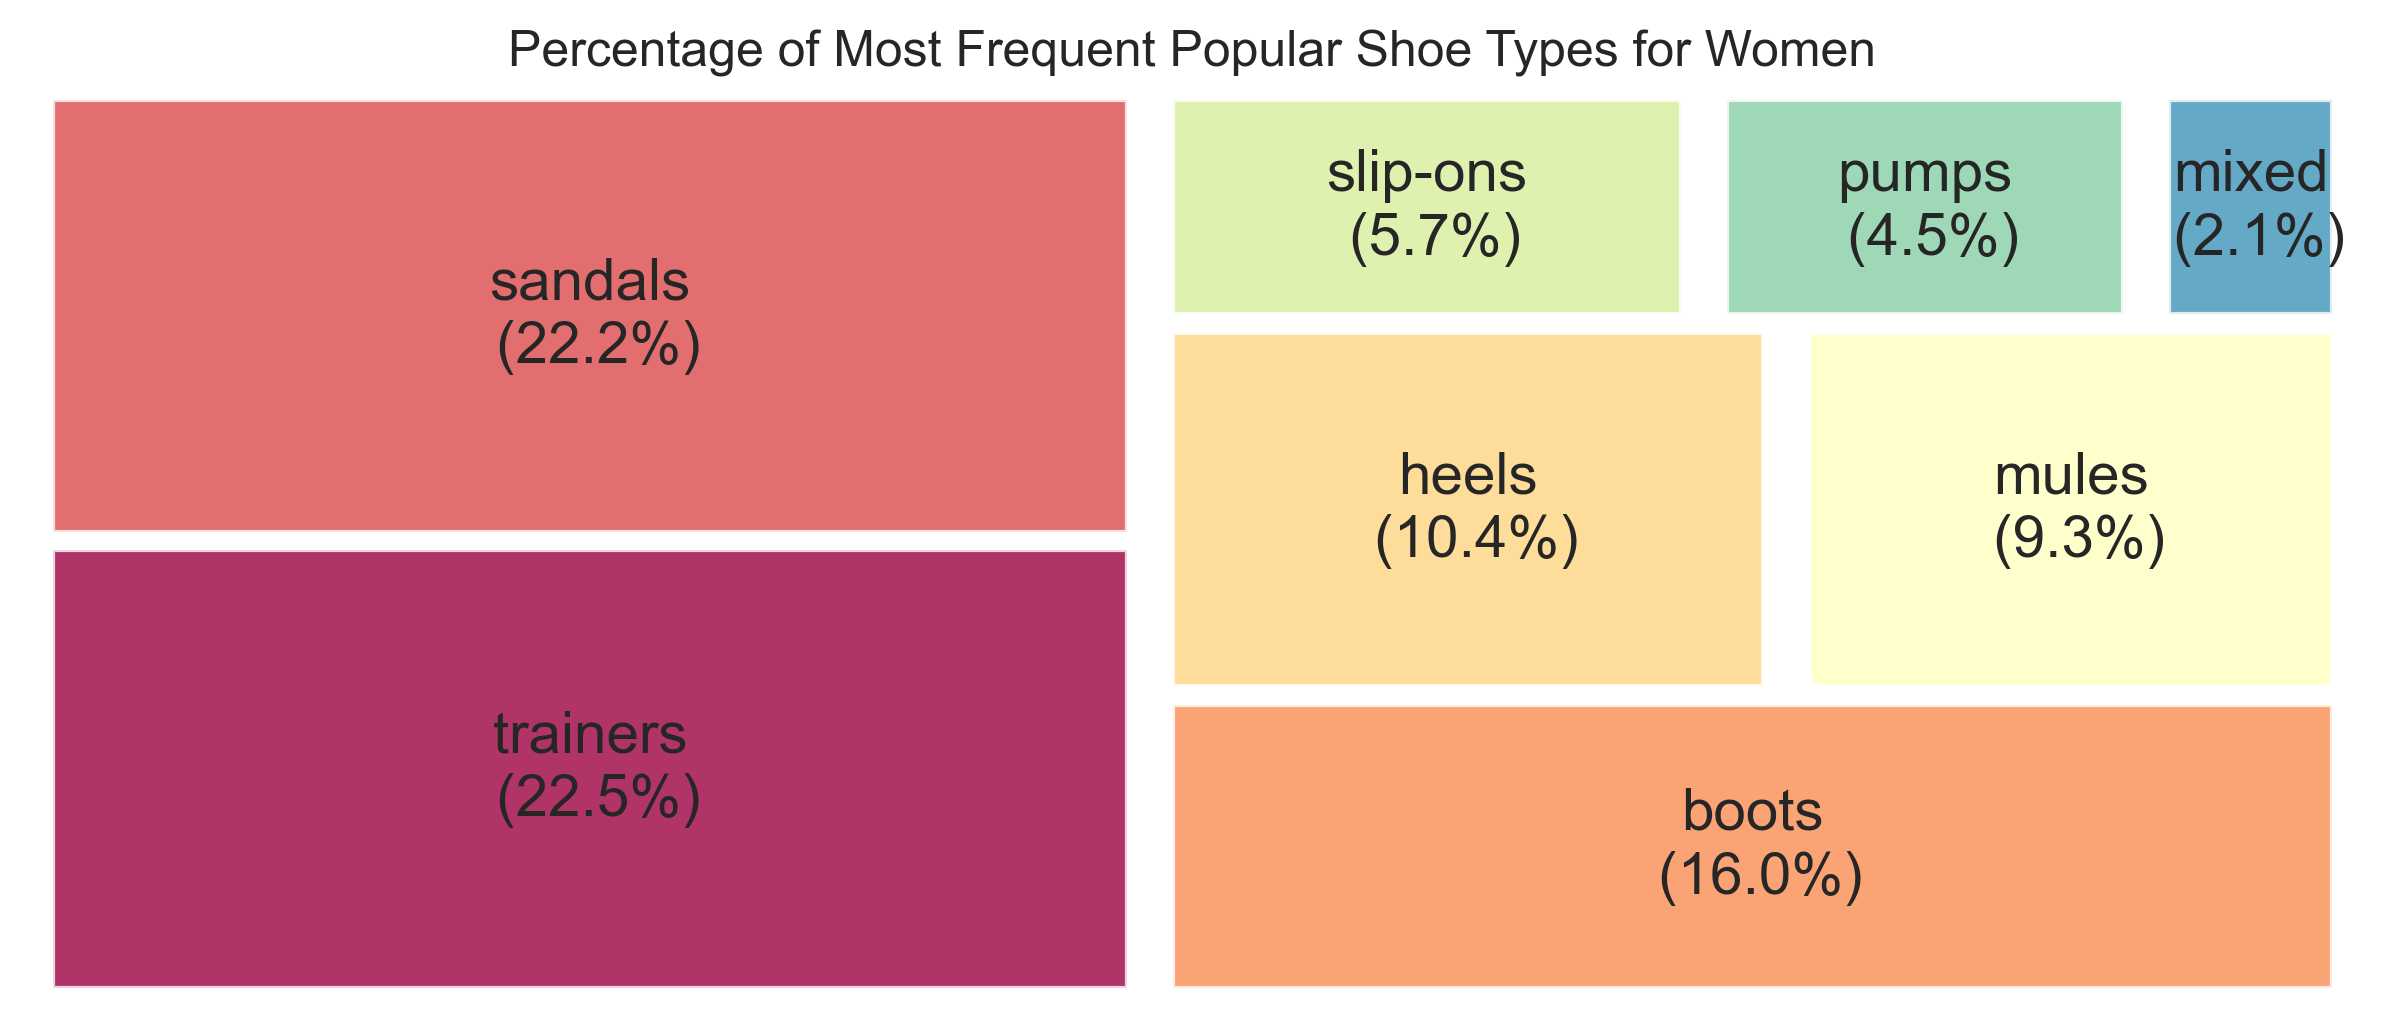

In [86]:
### visualize the relations of amount of shoe types with each other through a treemap diagram with squariy

treemapdf = pd.DataFrame(dset['shoetype'].str.lower().value_counts())
treemapdf['percentages'] = (100. * treemapdf['shoetype'] / treemapdf['shoetype'].sum())
treemapdf = treemapdf[~(treemapdf['percentages'] <= 2)]  

treemapdf['type'] = treemapdf.index
treemapdf.head()
#treemapdf['class3'] = (100. * treemapdf['class3'] / treemapdf['class3'].sum()).round(1)

label = treemapdf.apply(lambda x: str(x[2]) + "\n (" + str(round(x[1],1)) + "%)", axis=1)
colors= [plt.cm.Spectral(i/float(len(label))) for i in range(len(label))]
sb.set_style(style="whitegrid") # set seaborn plot style
sizes= treemapdf["percentages"].values# proportions of the categories
#label=treemapdf["type"]
label = treemapdf.apply(lambda x: str(x[2]) + "\n (" + str(round(x[1],1)) + "%)", axis=1)
#fig = plt.figure(figsize=(14,6))
#ax = fig.add_suplot()
#fig, ax = plt.subplot(nrows=1, ncols=2)

plt.figure(figsize=(10,4), dpi= 300)
squarify.plot(sizes=sizes, norm_x=100, label=label, alpha=0.8, color=colors, pad=6, text_kwargs={'fontsize': 14})
#axis = squarify.plot(dset['class3'].value_counts(),
#                     label=dset['class3'].value_counts().index,
#                     color=sb.color_palette("tab20", len(
#                         dset['class3'].value_counts())),
#                     pad=1,
#                     text_kwargs={'fontsize': 14})
plt.title('Percentage of Most Frequent Popular Shoe Types for Women')
plt.axis('off')
plt.show()

This is by the way such a summer collection of shoes - which leaves me with the question: who wears boots now?? We had some rainy days but still...

In [87]:
### let's do this diagram with plotly

treemapdf = pd.DataFrame(dset['shoetype'].str.lower().value_counts())
treemapdf['percentages'] = (100. * treemapdf['shoetype'] / treemapdf['shoetype'].sum())
treemapdf['type'] = treemapdf.index

fig = px.treemap(treemapdf, 
                 path=['type'],  # Specify the hierarchy column
                 values='percentages')      # Specify the values column
fig.show()


C:\Users\DPaulssen\anaconda3_2\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



73


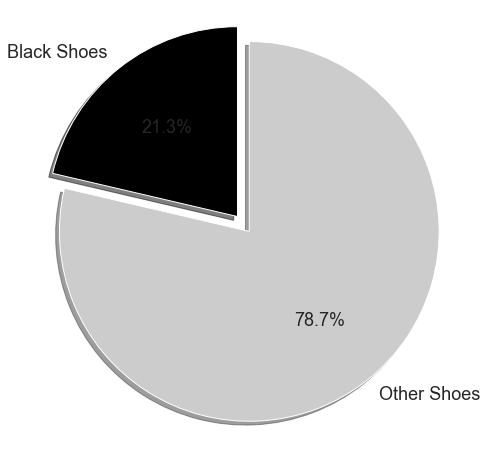

In [88]:
### percentage of black shoes

wshoes = len(dset[dset['colour'] == 'white'])
blshoes = len(dset[dset['colour'] == 'black'])
rshoes = len(dset[dset['colour'] == 'red'])
brshoes = len(dset[dset['colour'] == 'brown'])
nblshoes = len(dset[dset['colour'] != 'black'])
blushoes = len(dset[dset['colour'] == 'blue'])
print(blushoes)

labels = 'Black Shoes', 'Other Shoes'
sizes = [blshoes, nblshoes]
colors = ['0','0.8']
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(12,12), dpi= 300)
ax1.pie(sizes, colors=colors, explode=explode, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 18}, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [89]:
### with plotly

custom_colors = ['black', 'grey']

fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, pull=[0.2, 0], marker=dict(colors=custom_colors))])

fig.show()


In [90]:
### how big is the difference between original price and current price

dset['originalpr'] = dset.originalpr.astype(str).apply(lambda x: x.strip())
dset['originalpr'][dset.originalpr == '<NA>'] = str('0')
dset['originalpr'] = dset['originalpr'].apply(lambda x: x.replace('From', ''))
dset['originalpr'] = pd.to_numeric(dset['originalpr'])

dset['price'] = dset.price.astype(str).apply(lambda x: x.strip())
dset['price'] = dset['price'].apply(lambda x: x.replace('From', ''))
dset['price'][dset.price == '<NA>'] = str('0')
dset['price'] = pd.to_numeric(dset['price'])

dset['bargain'] = dset.originalpr - dset.price
offer = dset['bargain'].value_counts().get(0, 0)
allshoes = len(dset.index)
nonredu = allshoes - offer

print(nonredu)

7267


C:\Users\DPaulssen\AppData\Local\Temp\ipykernel_13192\2106388406.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DPaulssen\AppData\Local\Temp\ipykernel_13192\2106388406.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



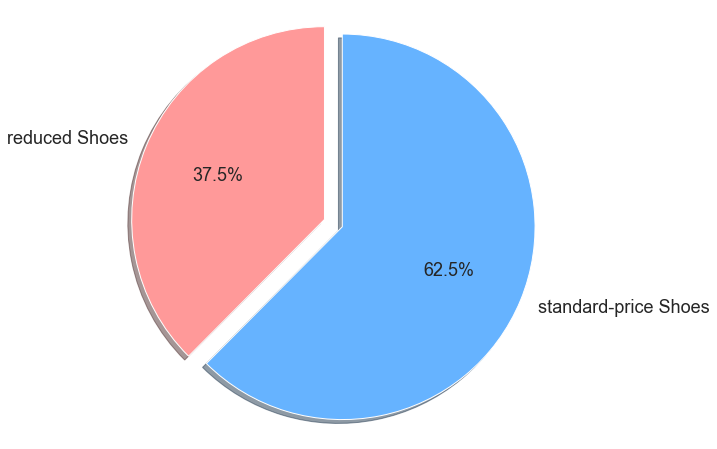

In [91]:
### new pie plot with this info

labels = 'reduced Shoes', 'standard-price Shoes'
sizes = [offer, nonredu]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8, 8))
#plt.figure(figsize=(12,12), dpi= 300)
ax1.pie(sizes, colors=colors, explode=explode, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 18}, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [92]:
### variations in bargain prices

bargains = pd.DataFrame(dset[dset['bargain'] != 0])

fig = px.box(bargains, y='bargain', title='Distribution of current price reductions')
fig.show()


In [95]:
### cheapest shoe, most expensive shoe, most reduced shoe

# cheapest price

#dset['absobargain'] = dset[['price']].min(axis=1)
#mindf = dset.loc[dset['absobargain'] != 0.0]
cheap = dset.price.min(axis=0)

# most expensive

#dset['pricy'] = dset[['price','offer']].max(axis=1)
expensive = dset.price.max(axis=0)

# most reduced
superreduced = dset.bargain.max(axis=0)

print(superreduced)

293.6


In [96]:
### plot prices per shoe type

fig = px.scatter(dset, x='shoetype', y='price', color='shoetype',
                 title='Price distribution per shoe type')
fig.update_traces(marker=dict(size=12, opacity=0.7), textposition='bottom center')

fig.show()


In [97]:
### shoe type with most brands

agg_df = dset.groupby('shoetype')['brand'].nunique().reset_index()
agg_df = agg_df.rename(columns={'brand': 'unique_brands'})

fig = px.bar(agg_df, x='shoetype', y='unique_brands', color='shoetype',
             title='Number of Unique Brands by Model Type')
fig.show()




In [98]:
### shoe type with most colours

agg_df = dset.groupby('shoetype')['colour'].nunique().reset_index()
agg_df = agg_df.rename(columns={'colour': 'unique_colours'})

fig = px.bar(agg_df, x='shoetype', y='unique_colours', color='shoetype',
             title='Number of Unique Colours by Model Type')
fig.show()

In [ ]:
### radar chart

In [99]:
### save cleaned data

dset.to_csv('shoe_attr2.csv')

##

## 4. Actual dashboarding with dash

Dash was chosen as it is completely covered by ChatGPT: https://www.youtube.com/watch?v=gs4d0_AKQi8&ab_channel=Plotly
However, I could only use ChatGPT as a tool as I had an elaborate data exploration before. It took ChatGPT 7 tries to get things right (as I wanted them - I have to work on my beautify prompts besides the general issue that ChatGPT may use different versions). However, I learned a lot. Now the dashboard only needs to be pimped... Was using chatgpt quicker than writting the code myself: only because of stackoverflow where the newest version problems were discussed. Nevertheless, ChatGPT provided a quick first frame that would have required a lot longer for simply typing...

In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# Load the data
url = "https://raw.githubusercontent.com/TomatoGreen2/WebScrapping-Dashboarding-Regression/main/shoe_attr2.csv"
df = pd.read_csv(url)

# Calculate the percentage of each shoe type
shoe_type_counts = df['shoetype'].value_counts()
total_shoes = len(df)
shoe_type_percentages = (shoe_type_counts / total_shoes) * 100
shoe_type_data = pd.DataFrame({'Shoe Type': shoe_type_percentages.index, 'Percentage': shoe_type_percentages.values})

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Shoe Dashboard"),
    
    # Treemap for shoe type percentage
    dcc.Graph(id='treemap'),
    
    # Scatter plot for prices per shoe type
    dcc.Graph(id='scatterplot'),
    
    # Pie chart for distribution of current price reductions
    dcc.Graph(id='piechart'),
])

# Define callback functions to update the graphs
@app.callback(
    [Output('treemap', 'figure'),
     Output('scatterplot', 'figure'),
     Output('piechart', 'figure')],
    Input('treemap', 'selectedData')  # You can add other inputs here if needed
)
def update_graphs(selected_data):
    # Treemap for shoe type percentage
    treemap = px.treemap(shoe_type_data, path=['Shoe Type'], values='Percentage', title="Shoe Type Percentage")
    
    # Scatter plot for prices per shoe type
    scatterplot = px.scatter(df, x='shoetype', y='price', color='shoetype', title="Prices per Shoe Type")
    scatterplot.update_traces(marker=dict(size=10))
    scatterplot.update_layout(font=dict(family='Arial', size=12))
    
    # Pie chart for distribution of current price reductions
    price_reductions = df['bargain'].apply(lambda x: 'reduced shoes' if x != 0 else 'standard-price')
    price_reduction_counts = price_reductions.value_counts()
    
    labels = price_reduction_counts.index
    values = price_reduction_counts.values
    colors = ['lightskyblue', 'lightcoral']
    pull = [0.1, 0]  # Explode out the first category
    
    piechart = go.Figure(data=[go.Pie(labels=labels, values=values, pull=pull, marker=dict(colors=colors))])
    piechart.update_layout(title="Distribution of Current Price Reductions")
    
    return treemap, scatterplot, piechart

if __name__ == '__main__':
    app.run_server(debug=True)


##

## 5. Outtakes

my personal reminders for future work...

In [ ]:
### outtakes:

#page_source = driver.page_source

#driver.close() 

#soup1 = BeautifulSoup(page_source,features="html.parser")

#print(soup1)

In [ ]:
# outtakes

#from bs4 import BeautifulSoup
#from urllib.request import Request, urlopen
#import re

#req = Request("https://www.faz.net/aktuell/feuilleton/buecher/")
#html_page = urlopen(req)

#soup = BeautifulSoup(html_page, "lxml")

#links = []
#for link in soup.findAll('a'):
#    links.append(link.get('href'))
    

#lis2 = []
#for l in links: #filter out NoneType
#    if type(l) == str:
#        lis2.append(l)
        
#new_list = [x for x in lis2 if "rezensionen" in x]

#print(len(new_list))

In [ ]:
### outtakes

#from selenium import webdriver
#from selenium.webdriver.support.ui import WebDriverWait
#from selenium.webdriver.support import expected_conditions as EC
#from selenium.webdriver import ActionChains

#from bs4 import BeautifulSoup
#import codecs
#import re

#driver = webdriver.Firefox()

In [ ]:
### outtakes
### get all pages with zalando shoes on its first page

#from selenium.webdriver.common.by import By
#from selenium.common.exceptions import TimeoutException, NoSuchElementException, StaleElementReferenceException

#url1 = 'https://www.zalando.de/damenschuhe/'

#driver.get(url1)

#elems = driver.find_elements("xpath", "//a[@href]")
#driver.execute_script('arguments[0].click()', elems)

#webadr = []
#for elem in elems:
#    try:
#        x = elem.get_attribute("href")
#        webadr.append(x)
#    except StaleElementReferenceException: 
#        pass


#new_list = [x for x in webadr if "html" in x]


#driver.close()

#print(webadr)

In [ ]:
### outtakes
### get additional shoe pages further down the list
# this solution takes 1 hour -> try different scraper

#from tqdm import tqdm


#indexlist = list(range(2, 201))
#webadrlist = []
#webadrlist.append(new_list)

#with tqdm(total = len(indexlist)) as pbar:
#for y in tqdm(indexlist):
#    url2 = 'https://www.zalando.de/damenschuhe/?p='
#    value = url2 + str(y)
#    driver.get(value)

#    elems = driver.find_elements("xpath", "//a[@href]")
#    webadr2 = []
#    for elem in elems:
#        try:
#            z = elem.get_attribute("href")
#            webadr2.append(z)
#        except StaleElementReferenceException: 
#            pass
#    new_list2 = [x for x in webadr2 if "html" in x]
#    webadrlist.append(new_list2)
#    pbar.update(y)

#bar.finish()
#flat_list = [item for sublist in webadrlist for item in sublist]

#import pandas as pd

#df = pd.DataFrame(flat_list)
#df.to_csv('flat_list.csv', index=False)

In [ ]:
#outtakes
#### web scrap zalando with cfscrape
#

#from bs4 import BeautifulSoup as bs
#import cfscrape
#import json
#import re
#import js2py

#url1 = 'https://www.zalando.de/damenschuhe/'

#headers = {
#    "accept": "application/json",
#    "content-type": "application/json",
#    "authorization": "Basic AUTH"
#}

#scraper = cfscrape.CloudflareScraper()
#response = scraper.get(url1, headers=headers)
#soup = bs(response.content, "html.parser")

In [ ]:
### outtakes
#from bs4 import BeautifulSoup as bs
#import cfscrape
#from tqdm import tqdm

#soups = []
#for url in tqdm(urls[1:4]):
#    headers = {
#        "accept": "application/json",
#        "content-type": "application/json",
#        "authorization": "Basic AUTH"
#    }
#    scraper = cfscrape.CloudflareScraper()
#    response = scraper.get(url, headers=headers)
#    soup = bs(response.content, "html.parser")
#    soups.append(soup)